# In Situ Comparison

In [1]:
import sys
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import glob
import calendar
import seaborn as sns
sys.path.append('/g/data/qz03/wp3/code/git-repo')
from utils import *
from scipy import stats

In [2]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)

In [3]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33581,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35293,Total threads: 1
Dashboard: /proxy/45703/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:35693,


## Domain and data availability plots

### Solar data availability

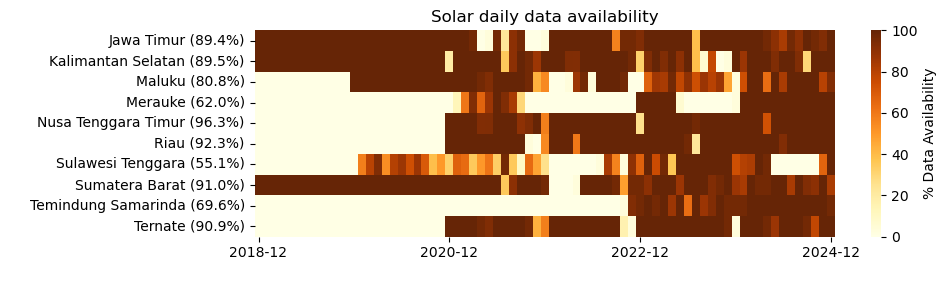

<Figure size 640x480 with 0 Axes>

In [39]:
solar_station_latlon_df = pd.read_csv('/g/data/qz03/wp3/data/obs/solar/station_metadata.csv').drop(columns=['No']).dropna()

files = ['/g/data/qz03/wp3/data/obs/solar/'+station_csv for station_csv in os.listdir('/g/data/qz03/wp3/data/obs/solar') if 'station_metadata' not in station_csv]
dfs = {f.split('/')[-1].replace('.csv',''): pd.read_csv(f) for f in files}

months_list = []
for df in dfs.values():
    df['Date'] = pd.to_datetime(df['Date'])
    months_list.append(df['Date'].dt.tz_convert(None).dt.to_period('M').drop_duplicates())

all_months = pd.Index(pd.concat(months_list).drop_duplicates()).sort_values()

availability = pd.DataFrame(index=dfs.keys(), columns=all_months.astype(str))
for station, df in dfs.items():
    df['year_month'] = df['Date'].dt.tz_convert(None).dt.to_period('M')
    total_per_month = df.groupby('year_month').size()
    avail_per_month = df.groupby('year_month')['GHI_sum'].apply(lambda x: (x.notna() & (x != 0)).sum()) 
    pct = (avail_per_month / total_per_month).reindex(all_months, fill_value=0) * 100
    availability.loc[station] = pct.values
    
availability.index = availability.index.str[:5]
new_index = []
for station, df in dfs.items():
    total = len(df)
    available = (df['GHI_sum'].notna() & (df['GHI_sum'] != 0)).sum()
    percent = (available / total) * 100 if total > 0 else 0
    label = f"{station.split('_')[1]} ({percent:.1f}%)"
    new_index.append(label)

availability.index = new_index
availability.sort_index(inplace=True)
plt.figure(figsize=(10, len(dfs)*0.05 + 2.5))
sns.heatmap(availability.astype(float), cmap='YlOrBr', cbar_kws={'label': '% Data Availability'}, xticklabels=24)
plt.title("Solar daily data availability")
plt.ylabel(' ')
plt.xlabel(' ')
plt.tight_layout()
plt.show()
plt.clf()

In [40]:
solar_station_latlon_df.sort_values(by='Station Name', inplace=True)
solar_station_latlon_df['status'] = [1, 1, 1, 2, 1, 1, 2, 1, 2, 1]
solar_station_latlon_df

,Station Name,Lat,Lon,status
2,Jawa Timur,-7.901390,112.596670,1
3,Kalimantan Selatan,-3.462250,114.840840,1
8,Maluku,-3.338810,128.368450,1
9,Merauke,-8.387090,140.516500,2
5,Nusa Tenggara Timur,-10.139000,123.666900,1
1,Riau,0.411970,101.216930,1
6,Sulawesi Tenggara,-4.056220,122.449160,2
0,Sumatera Barat,-0.550000,100.370000,1
4,Temindung Samarinda,-0.374146,117.253808,2
7,Ternate,0.825940,127.381300,1


### Wind and rain data availability

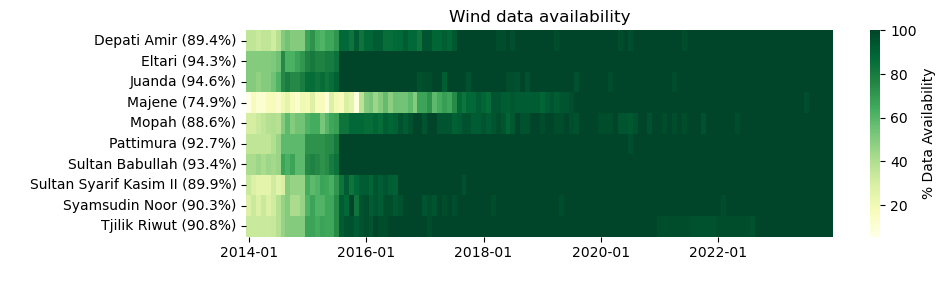

<Figure size 640x480 with 0 Axes>

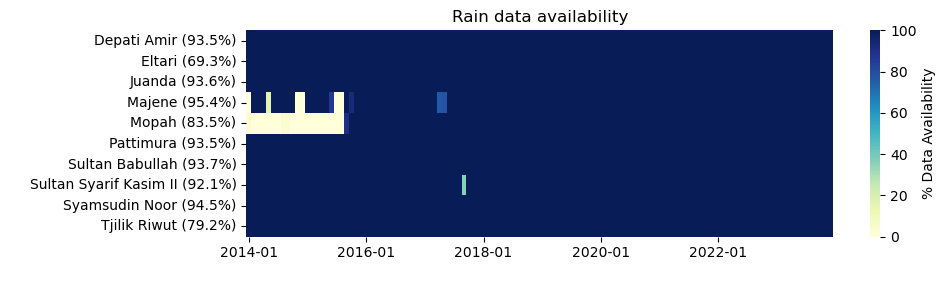

<Figure size 640x480 with 0 Axes>

In [48]:
wind_station_latlon_df = pd.read_csv('/g/data/qz03/wp3/data/obs/wind-and-rain/wind/station_metadata.csv').drop(columns=['No']).dropna()

for var in ['wind', 'rain']:
    files = [f'/g/data/qz03/wp3/data/obs/wind-and-rain/{var}/'+station_csv for station_csv in os.listdir(f'/g/data/qz03/wp3/data/obs/wind-and-rain/{var}') if 'station_metadata' not in station_csv]
    dfs = {f.split('/')[-1].replace('.csv',''): pd.read_csv(f, parse_dates=['DATA TIMESTAMP']) for f in files} if var == 'wind' else {f.split('/')[-1].replace('.csv',''): pd.read_csv(f, parse_dates=['time_step']) for f in files}
    
    df_list = []
    for df in dfs.values():
        df_list.append(df['DATA TIMESTAMP'].dt.to_period('M').drop_duplicates()) if var == 'wind' else df_list.append(df['time_step'].dt.to_period('M').drop_duplicates()) 
    
    all_months = pd.Index(pd.concat(df_list).drop_duplicates()).sort_values()
    
    availability = pd.DataFrame(index=dfs.keys(), columns=all_months.astype(str))
    for station, df in dfs.items():
        df['year_month'] = df['DATA TIMESTAMP'].dt.to_period('M') if var == 'wind' else df['time_step'].dt.to_period('M')
        total_per_month = df.groupby('year_month').size()
        avail_per_month = df.groupby('year_month')['WIND SPEED FF'].apply(lambda x: x.notna().sum()) if var == 'wind' else df.groupby('year_month')['WIND_SPEED_24H_MEAN_MS'].apply(lambda x: x.notna().sum())
        pct = (avail_per_month / total_per_month).reindex(all_months, fill_value=0) * 100
        availability.loc[station] = pct.values
        
    availability.index = availability.index.str[:5]
    new_index = []
    for station, df in dfs.items():
        total = len(df)
        available = df['WIND SPEED FF'].notna().sum() if var == 'wind' else df['RAINFALL_24H_MM'].notna().sum()
        percent = (available / total) * 100 if total > 0 else 0
        label = f"{wind_station_latlon_df[wind_station_latlon_df['WMO ID'] == int(station[:5])]['Station Name'].values[0]} ({percent:.1f}%)"
        new_index.append(label)
    
    availability.index = new_index
    availability.sort_index(inplace=True)
    plt.figure(figsize=(10, len(dfs)*0.05 + 2.5))
    sns.heatmap(availability.astype(float), cmap="YlGn" if var=='wind' else 'YlGnBu', cbar_kws={'label': '% Data Availability'}, xticklabels=24)
    plt.title(f"{'Wind' if var == 'wind' else 'Rain'} data availability")
    plt.ylabel(' ')
    plt.xlabel(' ')
    plt.tight_layout()
    plt.show()
    plt.clf()

In [49]:
wind_station_latlon_df.sort_values(by='Station Name', inplace=True)
wind_station_latlon_df['status'] = [1, 1, 1, 2, 2, 1, 1, 2, 1, 1]

In [50]:
wind_station_latlon_df

,Station Name,WMO ID,Lon,Lat,status
1,Depati Amir,96237.0,106.13000,-2.17000,1
6,Eltari,97372.0,123.67039,-10.16780,1
4,Juanda,96935.0,112.78330,-7.38460,1
5,Majene,97120.0,118.98054,-3.55074,2
9,Mopah,97980.0,140.41568,-8.52019,2
8,Pattimura,97724.0,128.09570,-3.71140,1
7,Sultan Babullah,97430.0,127.38000,0.83330,1
0,Sultan Syarif Kasim II,96109.0,101.44743,0.45924,2
3,Syamsudin Noor,96685.0,114.75400,-3.44200,1
2,Tjilik Riwut,96655.0,113.95000,-2.22000,1


### Domain plot with elevation

In [52]:
barra_topo = xr.open_dataset(f'{barraR2_dir}fx/orog/v20231001/orog_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc').sel(lat=slice(domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']), lon=slice(domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max']))

In [58]:
wind_station_latlon_dfwind_station_latlon_df['WMO ID'].astype(int).astype(str)

Station Name    Jawa Timur
Lat               -7.90139
Lon              112.59667
status                   1
Name: 2, dtype: object

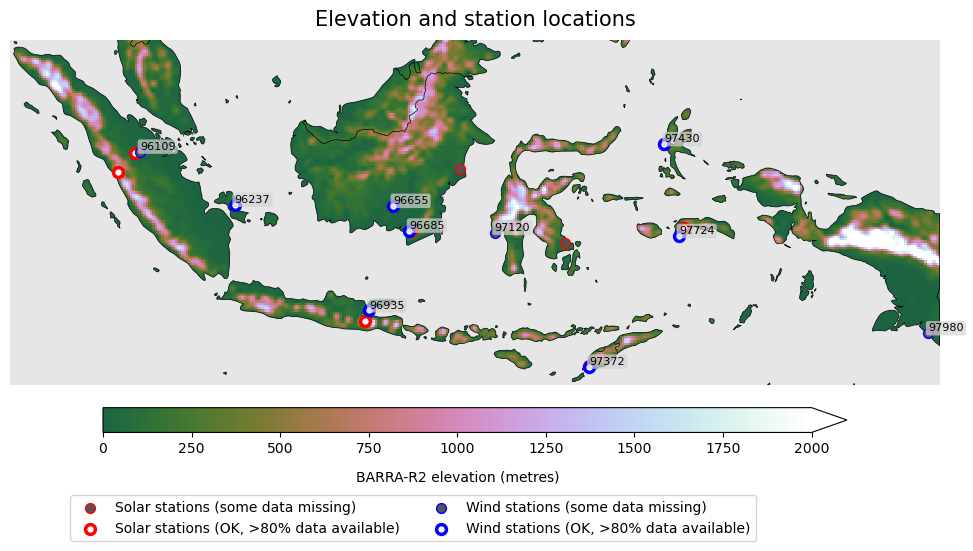

<Figure size 640x480 with 0 Axes>

In [71]:
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
contour = barra_topo.orog.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), vmax=2000, cmap=mcolors.LinearSegmentedColormap.from_list('trunc', plt.get_cmap('cubehelix')(np.linspace(5/17, 1, 256))), add_colorbar=False)
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', extend='max', shrink=0.8, aspect=30, pad=0.05)
cbar.set_label('BARRA-R2 elevation (metres)', labelpad=10)
ax.set_title("Elevation and station locations", size=15, pad=10)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black', zorder=10, alpha=1)
ax.add_feature(cfeature.LAND, linewidth=0.5, edgecolor='black', facecolor='none', zorder=10, alpha=1)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='#e6e6e6', alpha=1)
ax.set_frame_on(False)

ax.scatter(solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 2, 'Lon'], solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 2, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='#545353', edgecolor='red', s=50, linewidth=1, label='Solar stations (some data missing)', zorder=20)
ax.scatter(solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 1, 'Lon'], solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 1, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='white', edgecolor='red', s=50, linewidth=2.5, label='Solar stations (OK, >80% data available)', zorder=20)

ax.scatter(wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 2, 'Lon'], wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 2, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='#545353', edgecolor='blue', s=50, linewidth=1, label='Wind stations (some data missing)', zorder=20)
ax.scatter(wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 1, 'Lon'], wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 1, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='white', edgecolor='blue', s=50, linewidth=2.5, label='Wind stations (OK, >80% data available)', zorder=20)

# # Add labels for solar stations
# for _, row in solar_station_latlon_df.iterrows():
#     ax.text(row['Lon'], row['Lat']+0.5, row['Station Name'], transform=ccrs.PlateCarree(),
#             fontsize=8, ha='left', va='bottom', zorder=25, color='white')

# Add labels for wind stations
for _, row in wind_station_latlon_df.iterrows():
    ax.text(row['Lon'], row['Lat'], str(int(row['WMO ID'])), transform=ccrs.PlateCarree(),
            fontsize=8, ha='left', va='bottom', zorder=25, color='black', bbox=dict(facecolor='lightgrey', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))


ax.legend(ncol=2, bbox_to_anchor=(0.81, -0.3))
plt.show()
plt.clf()

## Solar

## Wind

In [130]:
wind_station_latlon_df = pd.read_csv('/g/data/qz03/wp3/data/obs/wind-and-rain/wind/station_metadata.csv').drop(columns=['No']).dropna()
wind_station_df = pd.concat([pd.read_csv(f, parse_dates=['DATA TIMESTAMP']).assign(station_id=f.split('_')[0].split('/')[-1]) for f in glob.glob('/g/data/qz03/wp3/data/obs/wind-and-rain/wind/*wind_2014_2023.csv')], ignore_index=True)#.replace(0, np.nan, inplace=True)
barra_winds_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/BARRAR2/1hr/sfcWind/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
era_u10_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/ERA5/10u/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').chunk({'time':-1, 'latitude':'auto', 'longitude':'auto'})
era_v10_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/ERA5/10v/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').chunk({'time':-1, 'latitude':'auto', 'longitude':'auto'})

In [131]:
del df

In [132]:
%%time
cols = ['dly_BARRA', 'mthly_BARRA', 'dly_ERA5', 'mthly_ERA5']
index = wind_station_latlon_df['WMO ID'].astype(int).astype(str)
R_df, p_df, MB_df, RMSE_df = (pd.DataFrame(columns=cols, index=index) for _ in range(4))
df_list = []
def compute_metrics(df, model_col, obs_col='WIND SPEED FF'):
    r, p = stats.pearsonr(df.dropna()[obs_col], df.dropna()[model_col])
    mb = (df.dropna()[model_col] - df.dropna()[obs_col]).mean()
    rmse = np.sqrt(((df.dropna()[model_col] - df.dropna()[obs_col]) ** 2).mean())
    return r, p, mb, rmse

for station_id in wind_station_latlon_df['WMO ID']:
    sid_str = f"{station_id:.0f}"
    lat, lon = wind_station_latlon_df.loc[wind_station_latlon_df['WMO ID'] == station_id, ['Lat', 'Lon']].values[0]
    station_df = wind_station_df[wind_station_df['station_id'] == sid_str].copy()
    station_df['DATA TIMESTAMP'] = pd.to_datetime(station_df['DATA TIMESTAMP'])

    barra_pt = barra_winds_hly['sfcWind'].sel(lat=lat, lon=lon, method='nearest').compute().sortby("time").resample(time="1D").mean()
    u10_pt = era_u10_hly.sel(latitude=lat, longitude=lon, method='nearest').compute()
    v10_pt = era_v10_hly.sel(latitude=lat, longitude=lon, method='nearest').compute()
    era5_pt = ((u10_pt.u10**2 + v10_pt.v10**2)**0.5).sortby("time").resample(time="1D").mean()

    df = pd.merge_asof(
        pd.merge_asof(
            station_df.sort_values('DATA TIMESTAMP'),
            barra_pt.to_series().reset_index(name='BARRA').sort_values('time'),
            left_on='DATA TIMESTAMP', right_on='time', direction='nearest'
        ).drop(columns='time'),
        era5_pt.to_series().reset_index(name='ERA5').sort_values('time'),
        left_on='DATA TIMESTAMP', right_on='time', direction='nearest'
    ).drop(columns='time')

    for freq, label in [('D', 'dly'), ('M', 'mthly')]:
        agg_df = df.copy()
        agg_df = agg_df.groupby([agg_df['DATA TIMESTAMP'].dt.to_period(freq), 'station_id']).mean(numeric_only=True).reset_index()

        for model in ['BARRA', 'ERA5']:
            r, p, mb, rmse = compute_metrics(agg_df, model)
            R_df.loc[sid_str, f'{label}_{model}'] = r
            p_df.loc[sid_str, f'{label}_{model}'] = p
            MB_df.loc[sid_str, f'{label}_{model}'] = mb
            RMSE_df.loc[sid_str, f'{label}_{model}'] = rmse
    df_list.append(df.groupby([df['DATA TIMESTAMP'].dt.to_period('D'), 'station_id']).mean(numeric_only=True).reset_index())
wind_station_df = pd.concat(df_list)

CPU times: user 1min 33s, sys: 24.5 s, total: 1min 57s
Wall time: 3min 2s


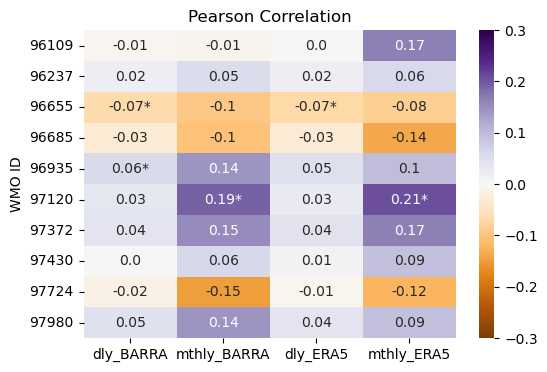

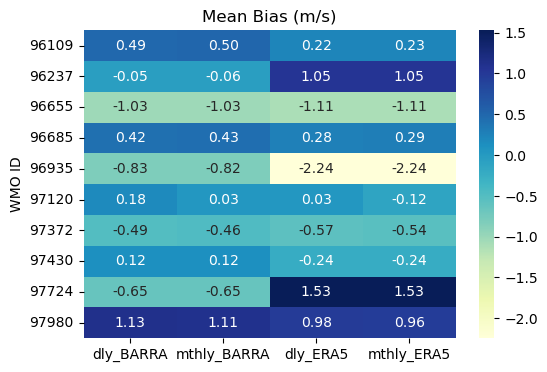

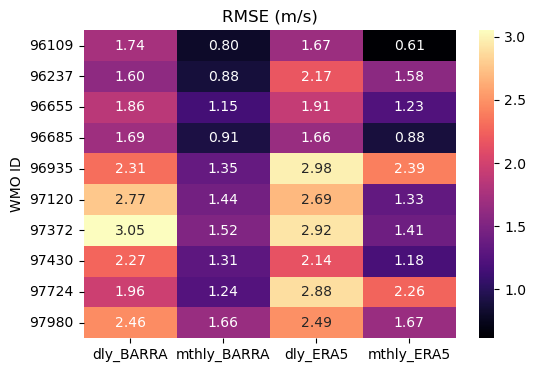

In [133]:
cmaps=['-', 'YlGnBu', 'magma']
titles=['-', 'Mean Bias (m/s)', 'RMSE (m/s)']
for plot_idx, plot_df in enumerate([R_df, MB_df, RMSE_df]):
    if plot_idx ==0:
        annot = (R_df.astype('float64').round(2).astype(str) + (p_df.astype('float64') < 0.05).astype(str).replace({'True': '*', 'False': ''}))
        plt.figure(figsize=(6, 4))
        sns.heatmap(R_df.astype('float64'), annot=annot, fmt="", vmin=-0.3, vmax=0.3, cmap="PuOr", cbar=True)
        plt.title('Pearson Correlation')
    else:
        plt.figure(figsize=(6, 4))
        sns.heatmap(plot_df.astype('float64'), cmap=cmaps[plot_idx], annot=True, fmt=".2f")
        plt.title(titles[plot_idx])

In [140]:
wind_station_df.replace(0, np.nan, inplace=True)
wind_station_df = wind_station_df.dropna()

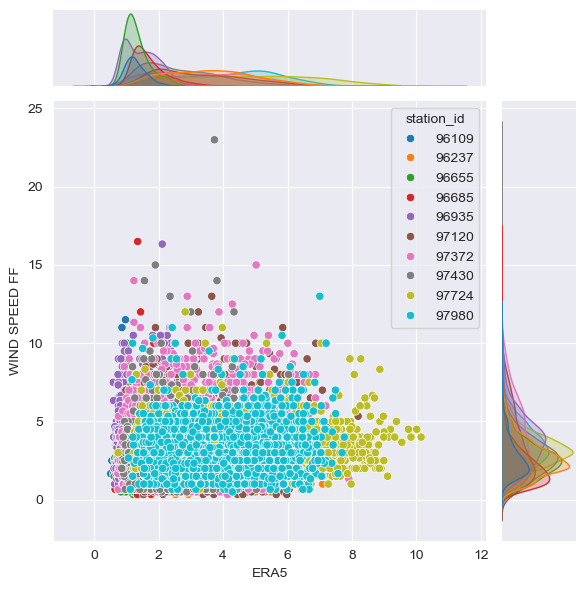

In [147]:
sns.jointplot(data=wind_station_df, x="ERA5", y="WIND SPEED FF", hue='station_id')

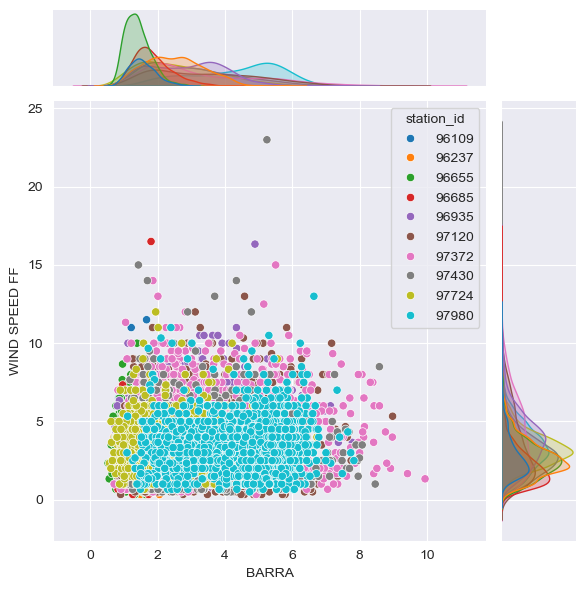

In [146]:
sns.jointplot(data=wind_station_df, x="BARRA", y="WIND SPEED FF", hue='station_id')

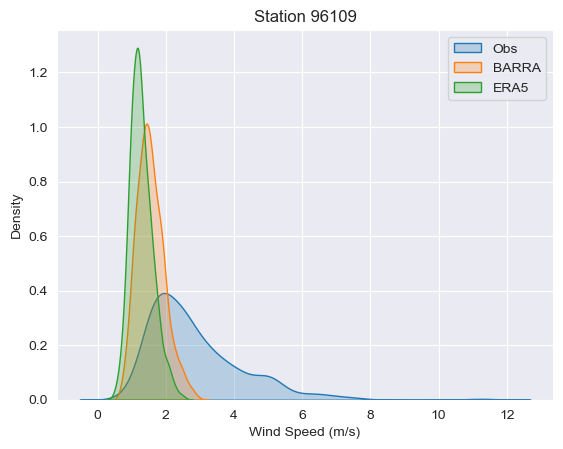

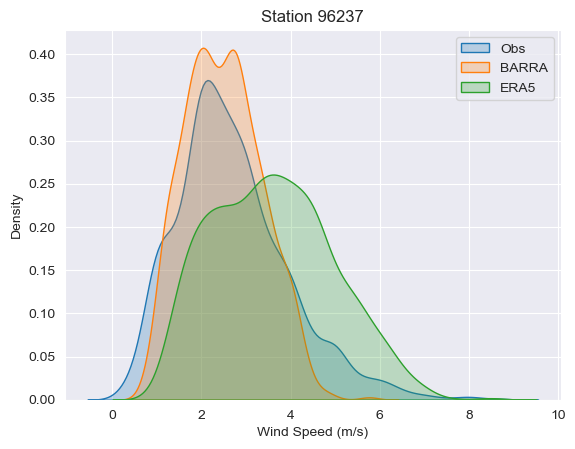

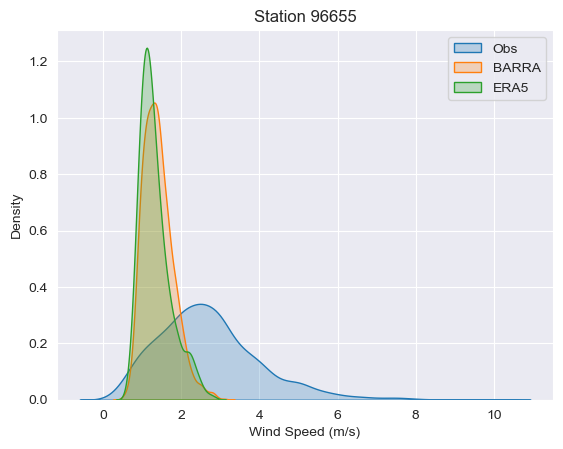

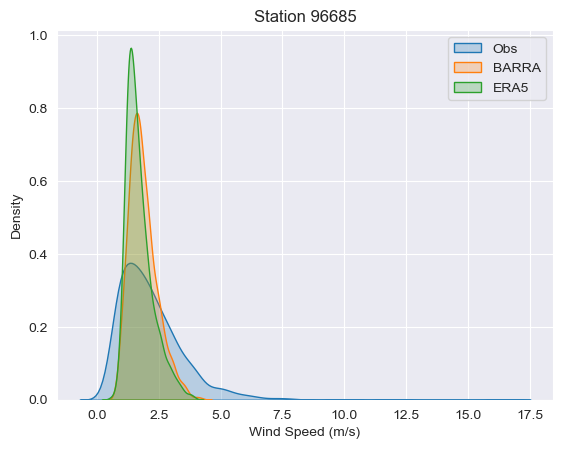

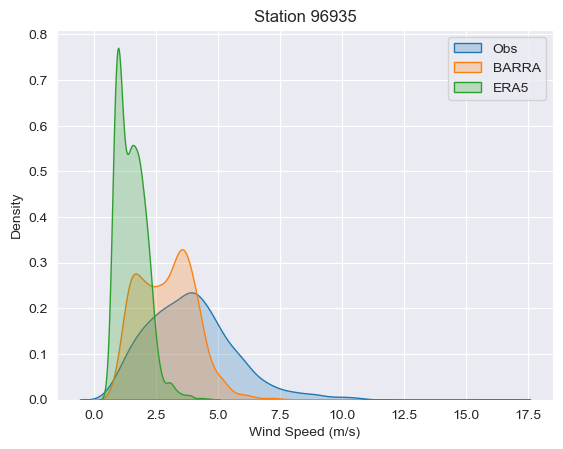

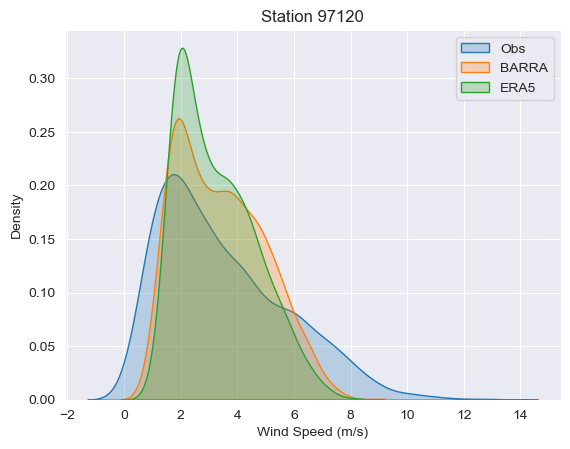

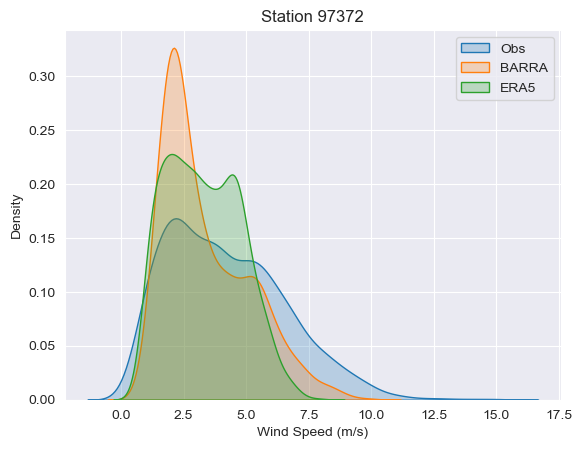

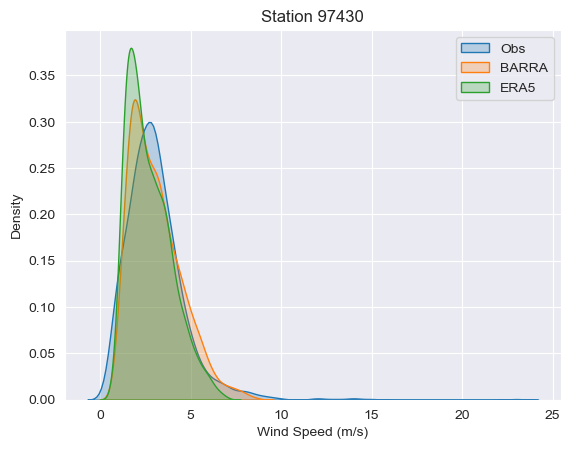

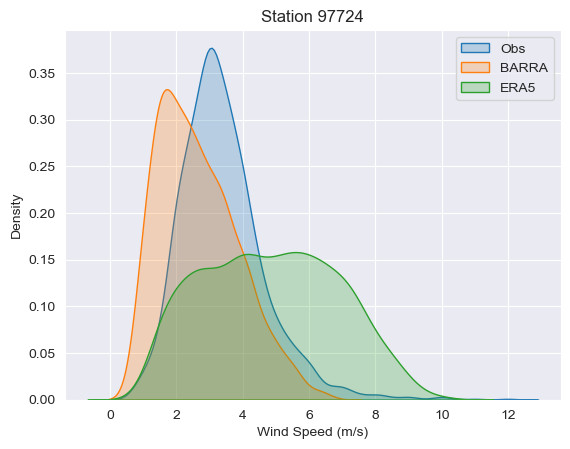

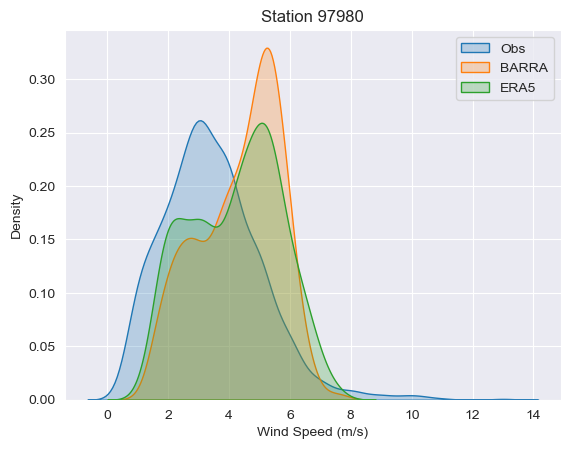

<Figure size 640x480 with 0 Axes>

In [149]:
for station in wind_station_df['station_id'].unique():
    plot_df = wind_station_df[wind_station_df['station_id']==station].dropna()
    sns.set_style("darkgrid")
    plot_df = wind_station_df[wind_station_df['station_id']==station]
    sns.kdeplot(data=plot_df, x="WIND SPEED FF", fill=True, label='Obs')
    sns.kdeplot(data=plot_df, x="BARRA", fill=True, label='BARRA')
    sns.kdeplot(data=plot_df, x="ERA5", fill=True, label='ERA5')
    plt.xlabel("Wind Speed (m/s)")
    plt.title(f"Station {station}")
    plt.legend()
    plt.show()
    plt.clf()

## Rainfall